In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, RandomAutocontrast, Resize, PILToTensor
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from collections import defaultdict
import csv
import pickle
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import math

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
device

'cuda'

In [3]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.le = LabelEncoder()

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('human_poses_data/train_answers.csv')
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            
            # Преобразуем метки в плотный диапазон 0-15
            original_labels = list(label_map.values())
            encoded_labels = self.le.fit_transform(original_labels)
            self.label_map = dict(zip(label_map.keys(), encoded_labels))
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image

In [4]:
transform = Compose([
    Resize((128, 192)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.4675, 0.4499, 0.4128), (0.2303, 0.2272, 0.2263)),
    # RandomAutocontrast(p=1.0),
])

train_data = Data(image_dir="human_poses_data/img_train",
                 train=True,
                 transform=transform)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(train_data.le, f)

test_set = Data(image_dir="human_poses_data/img_test",
                 train=False,
                 transform=transform)

# Стратифицированное разделение
labels = [train_data.label_map[int(img_name.split('.')[0])] for img_name in train_data.image_files]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, valid_indices = next(splitter.split(np.zeros(len(labels)), labels))

train_set = torch.utils.data.Subset(train_data, train_indices)
valid_set = torch.utils.data.Subset(train_data, valid_indices)


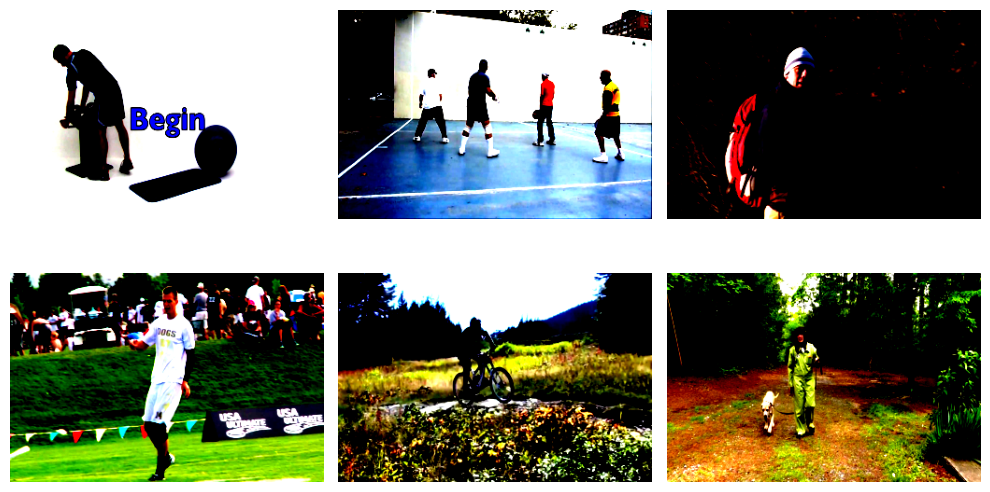

In [5]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        image, _ = dataset[i]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_data, num_images=6)

In [5]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        
        self.class_indices = defaultdict(list)
        for i, (_, label) in enumerate(original_dataset):
            self.class_indices[label].append(i)
        
        self.all_indices = []
        self.is_augmented = []
        
        self.augmentations = [
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=np.random.uniform(5, 15)),
            v2.ColorJitter(
                brightness=np.random.uniform(0.1, 0.3),
                contrast=np.random.uniform(0.1, 0.3),
                saturation=np.random.uniform(0.1, 0.3),
                hue=np.random.uniform(0.05, 0.15)
            ),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ]
        
        for label, indices in self.class_indices.items():
            current_count = len(indices)
            
            if current_count <= 300:
                needed = current_count * 5
            elif current_count <= 400:
                needed = current_count * 3
            elif current_count <= 500:
                needed = current_count * 2
            elif current_count <= 1000:
                needed = current_count
            else:
                needed = 0
            
            self.all_indices.extend([(idx, 0) for idx in indices])
            
            if needed > 0:
                aug_indices = np.random.choice(indices, size=needed, replace=True)
                self.all_indices.extend([(idx, 1) for idx in aug_indices])
    
    def __len__(self):
        return len(self.all_indices)
    
    def __getitem__(self, idx):
        original_idx, is_augmented = self.all_indices[idx]
        image, label = self.original_dataset[original_idx]
        
        if is_augmented:
            num_augs = np.random.randint(1, 4)
            selected_augs = list(np.random.choice(self.augmentations, size=num_augs, replace=False))
            transform = v2.Compose(selected_augs)
            image = transform(image)
        
        return image, label
    
balanced_train_set = BalancedDataset(train_set)

In [6]:
all_labels = [label for _, label in balanced_train_set]

# Вычисляем веса классов
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# Преобразуем в тензор и отправляем на устройство
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Выведем информацию о распределении классов
unique, counts = np.unique(all_labels, return_counts=True)
print("Class distribution after balancing:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count} samples")
print("\nClass weights:", dict(zip(unique, class_weights.cpu().numpy())))

Class distribution after balancing:
Class 0: 2010 samples
Class 1: 648 samples
Class 2: 1272 samples
Class 3: 1344 samples
Class 4: 1204 samples
Class 5: 1572 samples
Class 6: 1280 samples
Class 7: 1278 samples
Class 8: 1956 samples
Class 9: 1248 samples
Class 10: 1266 samples
Class 11: 1500 samples
Class 12: 1416 samples
Class 13: 1092 samples
Class 14: 1204 samples
Class 15: 1312 samples

Class weights: {np.int64(0): np.float32(0.671704), np.int64(1): np.float32(2.0835261), np.int64(2): np.float32(1.061419), np.int64(3): np.float32(1.0045573), np.int64(4): np.float32(1.1213663), np.int64(5): np.float32(0.85885817), np.int64(6): np.float32(1.0547851), np.int64(7): np.float32(1.0564358), np.int64(8): np.float32(0.69024795), np.int64(9): np.float32(1.081831), np.int64(10): np.float32(1.0664494), np.int64(11): np.float32(0.90008336), np.int64(12): np.float32(0.9534781), np.int64(13): np.float32(1.2363782), np.int64(14): np.float32(1.1213663), np.int64(15): np.float32(1.0290587)}


In [8]:
def count_classes(dataset):
    class_counts = defaultdict(int)
    
    for i in range(len(dataset)):
        _, label = dataset[i]
        class_counts[label] += 1
    
    print("Количество элементов по классам:")
    for class_id in sorted(class_counts.keys()):
        print(f"Класс {class_id}: {class_counts[class_id]} элементов")
    
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Класс')
    plt.ylabel('Количество элементов')
    plt.title('Распределение элементов по классам')
    plt.xticks(list(class_counts.keys()))
    plt.grid(True)
    plt.show()

class_counts = count_classes(train_set)
class_counts = count_classes(balanced_train_set)

KeyboardInterrupt: 

In [31]:
BATCH_SIZE = 64

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
def round_filters(filters, width_coeff):
    """Round number of filters based on width multiplier."""
    if width_coeff == 1.0:
        return filters
    return int(math.floor(filters * width_coeff + 0.5))

def round_repeats(repeats, depth_coeff):
    """Round number of repeats based on depth multiplier."""
    if depth_coeff == 1.0:
        return repeats
    return int(math.ceil(depth_coeff * repeats))

In [33]:
class MBConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, 
                 expansion=4, se_ratio=0.25, drop_connect_rate=0.2):
        super().__init__()
        self.stride = stride
        self.expansion = expansion
        hidden_dim = int(in_channels * expansion)
        reduced_dim = max(1, int(in_channels * se_ratio))
        self.use_residual = in_channels == out_channels and stride == 1
        
        # Expansion phase
        if expansion != 1:
            self.expand = nn.Sequential(
                nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(inplace=True)
            )
        else:
            self.expand = nn.Identity()
        
        # Depthwise convolution
        self.dw_conv = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride=stride, 
                     padding=kernel_size//2, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True)
        )
        
        # Squeeze-and-Excitation
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(hidden_dim, reduced_dim, 1),
            nn.SiLU(inplace=True),
            nn.Conv2d(reduced_dim, hidden_dim, 1),
            nn.Sigmoid()
        )
        
        # Output phase
        self.project = nn.Sequential(
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        self.drop_connect_rate = drop_connect_rate
        
    def drop_connect(self, x):
        if not self.training or self.drop_connect_rate == 0.:
            return x
        keep_prob = 1. - self.drop_connect_rate
        mask = torch.zeros(x.shape[0], 1, 1, 1, device=x.device).bernoulli_(keep_prob)
        return x / keep_prob * mask
        
    def forward(self, x):
        identity = x
        
        x = self.expand(x)
        x = self.dw_conv(x)
        x = x * self.se(x)
        x = self.project(x)
        
        if self.use_residual:
            x = self.drop_connect(x)
            x = x + identity
            
        return x

In [34]:
class EfficientNetB3(nn.Module):
    def __init__(self, num_classes=16, width_coeff=1.2, depth_coeff=1.4, 
                dropout_rate=0.3, drop_connect_rate=0.2):
        super().__init__()
        
        # EfficientNet-B3 configuration
        b3_config = [
            # expansion, out_channels, repeats, stride, kernel_size
            [1, 24, 1, 2, 3],    # Stage 1
            [6, 32, 2, 2, 3],     # Stage 2
            [6, 48, 2, 2, 5],     # Stage 3
            [6, 96, 3, 2, 5],     # Stage 4
            [6, 136, 3, 1, 5],    # Stage 5
            [6, 232, 4, 2, 5],    # Stage 6
            [6, 384, 1, 1, 5],    # Stage 7 (добавлен обратно для B3)
        ]
        
        # Stem
        out_channels = round_filters(40, width_coeff)  # Увеличенный размер для B3
        self.stem = nn.Sequential(
            nn.Conv2d(3, out_channels, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(inplace=True)
        )
        
        # Build blocks
        blocks = []
        in_channels = out_channels
        total_blocks = sum(round_repeats(x[2], depth_coeff) for x in b3_config)
        block_idx = 0
        
        for exp, ch, repeats, stride, k in b3_config:
            out_channels = round_filters(ch, width_coeff)
            repeats = round_repeats(repeats, depth_coeff)
            
            # First block of each stage
            blocks.append(MBConvBlock(
                in_channels, out_channels, 
                kernel_size=k,
                stride=stride,
                expansion=exp,
                drop_connect_rate=drop_connect_rate * block_idx / total_blocks
            ))
            block_idx += 1
            in_channels = out_channels
            
            # Subsequent blocks
            for _ in range(1, repeats):
                blocks.append(MBConvBlock(
                    in_channels, out_channels,
                    kernel_size=k,
                    stride=1,
                    expansion=exp,
                    drop_connect_rate=drop_connect_rate * block_idx / total_blocks
                ))
                block_idx += 1
        
        self.blocks = nn.Sequential(*blocks)
        
        # Head
        final_channels = round_filters(1536, width_coeff)  # Увеличенный размер для B3
        self.head = nn.Sequential(
            nn.Conv2d(in_channels, final_channels, 1, bias=False),
            nn.BatchNorm2d(final_channels),
            nn.SiLU(inplace=True)
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(final_channels, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [35]:
model = EfficientNetB3(num_classes=16).to(device)
summary(model, (3, 128, 192))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 64, 96]           1,296
       BatchNorm2d-2           [-1, 48, 64, 96]              96
              SiLU-3           [-1, 48, 64, 96]               0
          Identity-4           [-1, 48, 64, 96]               0
            Conv2d-5           [-1, 48, 32, 48]             432
       BatchNorm2d-6           [-1, 48, 32, 48]              96
              SiLU-7           [-1, 48, 32, 48]               0
 AdaptiveAvgPool2d-8             [-1, 48, 1, 1]               0
            Conv2d-9             [-1, 12, 1, 1]             588
             SiLU-10             [-1, 12, 1, 1]               0
           Conv2d-11             [-1, 48, 1, 1]             624
          Sigmoid-12             [-1, 48, 1, 1]               0
           Conv2d-13           [-1, 29, 32, 48]           1,392
      BatchNorm2d-14           [-1, 29,

In [12]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

In [13]:
import gc
def clear_memory():
    torch.cuda.empty_cache()
    gc.collect()

clear_memory()

In [14]:
def run_epoch(model, dataloader, loss_function, optimizer=None):
    model.train() if optimizer is not None else model.eval()
    
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader, desc='Training' if optimizer else 'Evaluating'):
            X, y = X.to(device), y.to(device)
            
            # Очищаем память перед каждой итерацией
            if optimizer is None:
                with torch.no_grad():
                    pred = model(X)
            else:
                pred = model(X)
            
            loss = loss_function(pred, y)
            total_loss += loss.item()

            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                clear_memory()
            else:
                all_preds.extend(pred.argmax(dim=1).cpu().numpy())
                all_targets.extend(y.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    
    if optimizer is None:
        acc = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        return avg_loss, acc, f1
    return avg_loss, None, None

In [15]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

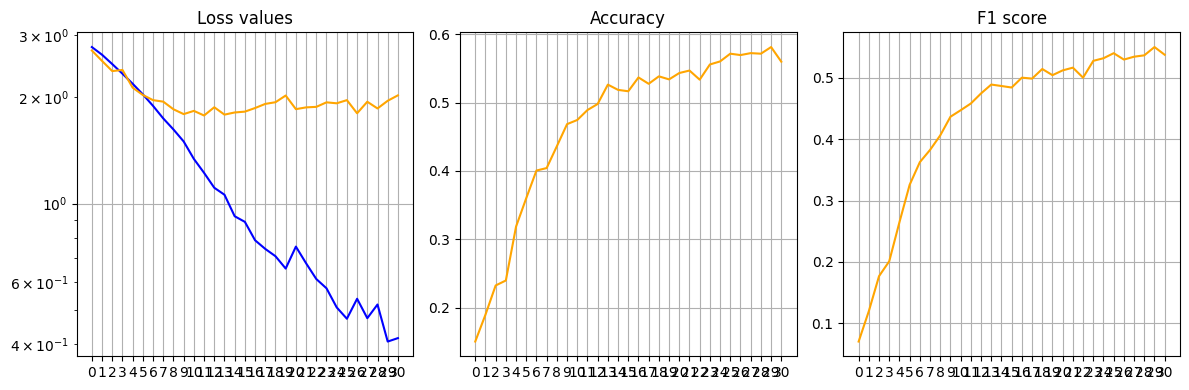

Current LR: 0.0003
Epoch 32/70


Training:  65%|██████▌   | 221/338 [07:01<03:59,  2.04s/it]

In [36]:
model = EfficientNetB3(num_classes=16).to(device)
NUM_EPOCHS = 70

loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = AdamW(model.parameters(), 
                lr=3e-4,
                weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

best_f1 = 0

train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    
    # Очистка памяти перед эпохой
    clear_memory()
    
    # Обучение и валидация
    train_loss, _, _ = run_epoch(model, train_loader, loss_function, optimizer)
    train_loss_hist.append(train_loss)

    test_loss, acc, f1_ = run_epoch(model, valid_loader, loss_function)
    test_loss_hist.append(test_loss)

    accuracy.append(acc)
    f1.append(f1_)
    
    scheduler.step(f1_)

    if f1_ > best_f1:
        best_f1 = f1_
        torch.save(model, 'best_model_efficient.pth')
        torch.save(model.state_dict(), 'best_model_efficient_weights.pth')
    
    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)
    print(f"Current LR: {optimizer.param_groups[0]['lr']}")
    clear_memory()


    

print(f"Min loss: {min(test_loss_hist):.6f}")
print(f"Max Accuracy: {max(accuracy):.4f}")
print(f"Max F1: {max(f1):.4f}")

In [17]:
# Получаем информацию о текущем устройстве (GPU)
total_memory = torch.cuda.get_device_properties(0).total_memory
allocated_memory = torch.cuda.memory_allocated()
reserved_memory = torch.cuda.memory_reserved()

print(f"Общая память GPU: {total_memory / (1024 ** 2):.2f} MiB")
print(f"Занятая память: {allocated_memory / (1024 ** 2):.2f} MiB")
print(f"Резервированная память: {reserved_memory / (1024 ** 2):.2f} MiB")

Общая память GPU: 4095.50 MiB
Занятая память: 73.58 MiB
Резервированная память: 102.00 MiB


In [19]:
from sklearn.metrics import classification_report
model = torch.load('best_model_efficient.pth', weights_only=False)
model.load_state_dict(torch.load('best_model_efficient_weights.pth'))
model = model.to(device)

y_true, y_pred = predict(model, valid_loader)
print(classification_report(y_true, y_pred))

100%|██████████| 78/78 [00:34<00:00,  2.25it/s]


              precision    recall  f1-score   support

           0       0.75      0.72      0.74       502
           1       0.50      0.33      0.40        27
           2       0.58      0.44      0.50       106
           3       0.61      0.63      0.62       336
           4       0.69      0.79      0.73       150
           5       0.73      0.70      0.72       196
           6       0.63      0.71      0.67       160
           7       0.74      0.70      0.72       107
           8       0.75      0.74      0.74       245
           9       0.56      0.69      0.62        78
          10       0.57      0.66      0.61       106
          11       0.87      0.88      0.88        94
          12       0.45      0.33      0.38        88
          13       0.56      0.52      0.54        46
          14       0.71      0.72      0.72       151
          15       0.74      0.82      0.78        82

    accuracy                           0.68      2474
   macro avg       0.65   

In [20]:
model = torch.load('best_model_efficient.pth', weights_only=False)
model.load_state_dict(torch.load('best_model_efficient_weights.pth'))
model = model.to(device)
model.eval()

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Подготовка для сохранения предсказаний
test_preds = []
test_ids = []

# Предсказание на тестовых данных
with torch.no_grad():
    for img_name in tqdm(test_set.image_files, desc="Processing test images"):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image).unsqueeze(0).to(device)  # Добавляем batch dimension
        
        output = model(image)
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])  # Извлекаем ID без расширения
        test_preds.append(pred.item())

original_labels = le.inverse_transform(test_preds)

# Сортируем по ID (если нужно)
test_ids, test_preds = zip(*sorted(zip(test_ids, original_labels), key=lambda x: int(x[0])))

# Сохраняем в CSV
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, test_preds))

print(f"Predictions saved to submission.csv, total {len(test_preds)} predictions")

Processing test images: 100%|██████████| 5301/5301 [01:57<00:00, 44.97it/s]

Predictions saved to submission.csv, total 5301 predictions
